In [2]:
%run bert.ipynb

attention pattern raw MATCH!!!!!!!!
 SHAPE (2, 12, 3, 3) MEAN: 0.004527 STD: 0.1067 VALS [-0.03032 0.07337 -0.2086 -0.08587 0.09546 -0.05553 0.01418 -0.1695 -0.06496 0.1636...]
attention MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.001966 STD: 0.1235 VALS [-0.1803 0.1231 0.0987 0.02869 0.1032 -0.008689 0.03242 -0.01018 -0.003862 0.0693...]
bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.001554 STD: 0.1736 VALS [-0.08316 -0.09165 -0.03188 -0.03013 0.1001 0.09549 -0.1046 0.07742 0.0424 0.05553...]
bert mlp MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.0001934 STD: 0.1044 VALS [-0.1153 0.1189 -0.0813 0.1021 0.0296 0.06182 0.0341 0.1446 0.2622 -0.08507...]
layer norm MATCH!!!!!!!!
 SHAPE (20, 10) MEAN: -1.431e-08 STD: 1.003 VALS [0.6906 -0.84 1.881 1.711 -0.5116 -0.9577 -0.1387 -0.6943 -0.6741 -0.4662...]
bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -5.381e-09 STD: 1 VALS [0.007132 -0.04372 0.6502 -0.5972 -1.097 0.7267 0.1275 -0.6035 -0.2226 0.2145...]
{'input_ids': [[101, 8667, 117, 146, 1821, 170

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import transformers
from tqdm.notebook import tqdm
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")

In [4]:
def make_bert():
    my_bert = Bert(
        vocab_size=28996, hidden_size=384, max_position_embeddings=512, 
        type_vocab_size=2, dropout=0.1, intermediate_size=1536, 
        num_heads=6, num_layers=2, num_classes=2
    )
    return my_bert

In [5]:
import torchtext
import random
from torch.utils.data import DataLoader
data_train, data_valid, data_test = torchtext.datasets.WikiText2(root='.data', split=('train', 'valid', 'test'))

data_train_list = list(data_train)

train_dataloader = DataLoader(data_train_list, batch_size=16, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=16)
valid_dataloader = DataLoader(data_test, batch_size=16)

In [6]:
bert = make_bert().cuda()
lossfn = nn.CrossEntropyLoss()

In [7]:
lr = 1e-4
optimizer = torch.optim.Adam(bert.parameters(), lr)

i=42700 epoch=18 loss=5.058466911315918


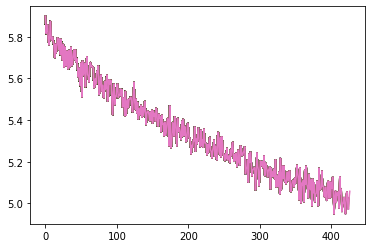

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import datetime
def train(model, optimizer, data, lossfn, epochs=1, max_seq_len=512):
    model.train()
    avg_losses = []
    loss_buffer = []
    i = 0
    for epoch in range(epochs):
        for X in tqdm(data):
            optimizer.zero_grad()
            
            # token processing
            tokens = tokenizer(X, padding='longest', max_length=max_seq_len, truncation=True)
            # the original input
            unmasked_tokens = torch.tensor(tokens.input_ids, dtype=torch.long).cuda()
            zero_tokens = unmasked_tokens == 0
            rand_nums = torch.rand(unmasked_tokens.shape).cuda() <= 0.15

            masked_tokens = unmasked_tokens.clone()
            masked_tokens[rand_nums] = tokenizer.mask_token_id
            masked_tokens[zero_tokens] = 0

            output, _classifications = model(masked_tokens)
            masked_mask = masked_tokens == tokenizer.mask_token_id
            #expected_output_at_masks = torch.masked_select(unmasked_tokens,    masked_mask)
            expected_output_at_masks = unmasked_tokens[masked_mask]
            unnormed_probs_at_masks = output[masked_mask]
            loss = lossfn(unnormed_probs_at_masks, expected_output_at_masks) 

            
            #print(unmasked_tokens)
            #print(masked_tokens)
            #print(output)
            #print(expected_output_at_masks)
            #print(unnormed_probs_at_masks)
            #break
            
            loss.backward()
            optimizer.step()
            loss_buffer.append(loss)
            i += 1
            if i % 100 == 0:
                avg_loss = sum(loss_buffer) / len(loss_buffer)
                avg_losses.append(avg_loss)
                loss_buffer.clear()
                if i % 5000 == 0:
                    time_string = datetime.datetime.now().strftime('%y%m%d-%H-%M')
                    torch.save(bert, f"saved_tiny_bert/{time_string}_loss{avg_loss}.pt")          
                
                print(f"{i=} {epoch=} loss={avg_loss}")
                plt.plot(avg_losses)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                             

train(bert, optimizer, train_dataloader, lossfn, epochs=100)

In [73]:
def ascii_art_probs(model, sentence):
    token_ids = torch.Tensor(tokenizer.encode(sentence)).long().unsqueeze(0)
    mask_idxs = set()
    for idx, token_id in enumerate(token_ids[0]):
        if token_id == 103: # 103 == [MASK]
            mask_idxs.add(idx)
    unnormalized_output, _classifications = bert(token_ids.cuda())
    output = torch.log_softmax(unnormalized_output, dim=-1)
    top_k = torch.topk(output, 5, dim=-1)
    results = []
    for seq_i, seq_top_k in enumerate(top_k.indices[0]):
        if seq_i in mask_idxs:
            results.append(list(zip(tokenizer.convert_ids_to_tokens(seq_top_k), [round(x.item(), 2) for x in top_k.values[0][seq_i].exp()])))
    for l in results:
        print(l)

ascii_art_probs(bert, "The [MASK] loves to eat.")

[('the', 0.09), (',', 0.02), ('of', 0.02), ('to', 0.01), ('was', 0.01)]
